# Table of contents
* [Project Brief](#project-brief)
* [Data Loading](#data-loading)
* [Initial Data Exploration](#initial-data-exploration)
    * [Samples, shapes and general stats](#samples)
    * [Nulls](#nulls)
    * [Timestamps](#timestamps)
    * [Language](#language)
* [Data Preparation](#data-preparation)
* [Data Visualisation](#data-visualisation)
    * [Correlation](#correlation)
    * [Timeseries](#timeseries)
    * [Wordcloud](#wordcloud)

# Project Brief <a class="anchor" id="project-brief"></a>

### Introduction
This project will use a twitter dataset containing ~350k tweets during a football match, specifically the 2017-2018 Champions League Final in which Real Madrid beat Liverpool 3-1. Twitter is a social media platform where users can post text content and associate it to a topic using hashtags. It provides a platform for people to share and debate opinions along with other content. At this stage there are two questions that I have framed, practically only one can be explored in the remaining time, with the second being a more ambitious target.

1. Is it possible to use a set of tweets to identify the occurence of key events in a football match? A real world application would be to create a "match commentary" bot that could be used by media outlets to generate real time match commentary.

2. Can sentiment analysis be used to predict the outcome of a football match? Real world applications of this include aiding bookmakers in generating real time odds through to providing football clubs with an alternative information source for in-game decision making

To assist with this analysis, I have also generated a dataset containing the ground truth of key events from the match itself. This can be seen in a dataframe named "full_game_context_df".

### Observations
#### Relevant fields
The twitter dataset contains 38 columns, of these I have identified the following as being most relevant to the questions I wish to answer above. This is largely based on the definitions from twitter documentation https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/tweet-object.
* id - The unique identifier for the tweet
* text - The tweet text
* extended_tweet - In some cases the tweet "text" is a truncated version of the full tweet, therefore in some cases extended_tweet will need to be used
* lang - The language of the tweet
* retweeted_status - Indicates whether a tweet is a retweet and provided detail on the tweet being retweeted
* created_at - The timestamp of the tweet
* user - This could be useful in identifying noise in the data, e.g. one user posting something similar content multiple times. However this will need further exploration as there will be genuine cases where users are publishing the same sentiment because it is based on what they are seeing/thinking.

#### Null Values
The tweets DataFrame shape indicated there were 354586 records, however value counts indicated less "id" values at 330384. Exploration showed that in all cases where id is NaN the tweet "text" was also NaN. Given the model I plan to build is reliant on the text field, any fields with NaN "id" will be excluded from analysis.

#### Language
Counts were generated for the number of tweets per language (top 5 listed below), as expected given the location of the two teams english and spanish topped the list. Given my spanish is limited, I will excluded non-english tweets. This will potentially introduce bias, and future work should look to translate text.
* en: 187592
* es: 47923
* pt: 15843
* und: 14978
* ar: 10655

#### Visualisation
Plotting the data as a time series based on the number of tweets per minute proved insightful, in that you can observe spikes in the number of tweets in game vs half time and additional spikes where key events occur.

Additionally plotting a word cloud proved insightful and identified the dislocated shoulder Mo Salah faced, this is an extremely specific event and gives a nice indication of what may be possible with this dataset.

### Next steps 
* Add "match minute" to the tweet dataset, this will provide a linkage to the context dataset which will be useful for visualisation and validation
* Consider what additional feature engineering should be performed
* Explore fields containing lists in more detail (extended_tweet, retweeted_status & user)

# Data Loading <a class="anchor" id="data-loading"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Load the dataset
full_tweets_df = pd.read_json('../input/tweets-during-r-madrid-vs-liverpool-ucl-2018/TweetsChampions.json', lines = True)

In [3]:
# Generate some contextual data using https://www.whoscored.com/Matches/1278491/Preview/Europe-Champions-League-2017-2018-Real-Madrid-Liverpool
# for now this is achieved manually but web scraping or finding an API equivalent would be the solution for a model running real time.
full_game_context_df = pd.DataFrame(np.array([['90+3','','','Second half ends'],
['90+1','','RMA','Marco Asensio wins a corner (To the left)'],
['91','','LIV','Adam Lallana has shot blocked (18-yard box, Left footed, Set piece)'],
['91','','RMA','Cristiano Ronaldo blocks a shot'],
['89','Sub Out','RMA','Karim Benzema is substituted off'],
['89','Sub In','RMA','Marco Asensio is substituted on'],
['86','','RMA','Luka Modric wins a corner (To the right)'],
['86','','RMA','Luka Modric wins a corner (To the right)'],
['85','','RMA','Gareth Bale wins a corner (To the right)'],
['83','Goal','RMA','GOAL! Gareth Bale scores , Assisted by Marcelo (High to the right, Out of box, Left footed, Open play)'],
['83','Sub Out','LIV','James Milner is substituted off'],
['83','Sub In','LIV','Emre Can is substituted on'],
['82','Yellow Card','LIV','Sadio Mané recieves a yellow card'],
['82','','RMA','Karim Benzema has attempt saved (High to the centre, 18-yard box, Right footed, Open play)'],
['82','','LIV','Loris Karius makes a save (Parried into danger, Diving)'],
['75','','RMA','Gareth Bale is caught offside'],
['74','','RMA','Cristiano Ronaldo wins a corner (To the left)'],
['74','','LIV','Andrew Robertson blocks a shot'],
['74','','RMA','Cristiano Ronaldo has shot blocked (18-yard box, Left footed, Open play)'],
['73','','LIV','Adam Lallana is caught offside'],
['70','Shot on post','LIV','Sadio Mané wins a corner (To the left)'],
['70','','LIV','Sadio Mané hits the woodwork (To the left, Out of box, Left footed, Open play)'],
['69','','LIV','Andrew Robertson wins a corner (To the left)'],
['69','','LIV','Adam Lallana is caught offside'],
['64','Goal','RMA','GOAL! Gareth Bale scores , Assisted by Marcelo (High to the left, 18-yard box, Left footed, Open play)'],
['61','Sub Out','RMA','Isco is substituted off'],
['61','Sub In','RMA','Gareth Bale is substituted on'],
['61','','RMA','Isco wins a corner (To the left)'],
['61','','RMA','Toni Kroos is caught offside'],
['61','','RMA','Isco misses attempt (18-yard box, Right footed, Open play)'],
['61','','LIV','Loris Karius makes a save (Diving, Parried safe, From shot off target)'],
['55','Goal','LIV','GOAL! Sadio Mané scores , Assisted by Dejan Lovren (Low to the centre, 6-yard box, Big Chance, Right footed, From corner)'],
['55','Assist','LIV','Dejan Lovren has shot blocked (18-yard box, Key pass, Head, From corner)'],
['54','','LIV','James Milner wins a corner (To the right)'],
['53','','RMA','Karim Benzema is caught offside'],
['51','Goal','RMA','GOAL! Karim Benzema scores (Low to the left, 18-yard box, Big Chance, Right footed, Open play)'],
['48','','RMA','Isco wins a corner (To the right)'],
['48','Shot on post','RMA','Isco hits the woodwork (High, 18-yard box, Big Chance, Right footed, Open play)'],
['46','','','Second half begins!'],
['45+3','','','First half ends'],
['45+2','','RMA','Karim Benzema misses attempt (Out of box, Right footed, Open play)'],
['45+1','','RMA','Marcelo wins a corner (To the left)'],
['45','','RMA','Nacho misses attempt (18-yard box, Right footed, Open play)'],
['44','','LIV','Roberto Firmino is caught offside'],
['43','','RMA','Cristiano Ronaldo has attempt saved (Low to the centre, 18-yard box, Big Chance, Head, Open play)'],
['43','','LIV','Loris Karius makes a save (Parried into danger, Diving)'],
['43','','RMA','Karim Benzema is caught offside'],
['41','','RMA','Cristiano Ronaldo is caught offside'],
['39','','RMA','Luka Modric wins a corner (To the right)'],
['37','Sub Out','RMA','Daniel Carvajal is substituted off'],
['37','Sub In','RMA','Nacho is substituted on'],
['33','','RMA','Karim Benzema has shot blocked (18-yard box, Right footed, Open play)'],
['33','','LIV','Virgil van Dijk blocks a shot'],
['32','','LIV','Andrew Robertson blocks a shot'],
['32','','RMA','Luka Modric has shot blocked (18-yard box, Right footed, Open play)'],
['31','Sub Out','LIV','Mohamed Salah is substituted off'],
['31','Sub In','LIV','Adam Lallana is substituted on'],
['28','','LIV','Sadio Mané wins a corner (To the left)'],
['23','','LIV','Trent Alexander-Arnold has attempt saved (Low to the centre, 18-yard box, Right footed, Open play)'],
['23','','RMA','Keylor Navas makes a save (Diving, Collected)'],
['23','','LIV','Roberto Firmino has shot blocked (18-yard box, Right footed, Open play)'],
['23','','RMA','Sergio Ramos blocks a shot'],
['20','','RMA','Isco is caught offside'],
['18','','LIV','Virgil van Dijk misses attempt (High to the left, 6-yard box, Big Chance, Head, From corner)'],
['18','','LIV','Trent Alexander-Arnold wins a corner (To the right)'],
['15','','RMA','Cristiano Ronaldo misses attempt (18-yard box, Right footed, Open play)'],
['14','','LIV','Sadio Mané has shot blocked (18-yard box, Right footed, Open play)'],
['14','','RMA','Daniel Carvajal blocks a shot'],
['14','','LIV','Mohamed Salah has shot blocked (18-yard box, Left footed, Open play)'],
['14','','RMA','Raphael Varane blocks a shot'],
['14','','LIV','James Milner has shot blocked (Out of box, Left footed, Open play)'],
['14','','RMA','Casemiro blocks a shot'],
['11','','RMA','Marcelo misses attempt (To the right, Out of box, Left footed, Open play)'],
['8','','LIV','Roberto Firmino misses attempt (High to the left, 18-yard box, Head, Open play)'],
['8','','','Formation Set'],
['6','','LIV','Mohamed Salah has shot blocked (Out of box, Left footed, Set piece)'],
['6','','RMA','Luka Modric blocks a shot'],
['3','','LIV','Georginio Wijnaldum has shot blocked (Out of box, Right footed, Open play)'],
['3','','RMA','Casemiro blocks a shot'],
['2','','RMA','Isco is caught offside'],
['1','','','First half begins!']]), columns=['match_minute', 'event_type', 'team', 'event_text'])

# Initial Data Exploration <a class="anchor" id="initial-data-exploration"></a>

## Samples, Shapes & General Stats <a class="anchor" id="samples"></a>

In [4]:
# Print the shape of each dataset
print(f'full_tweets_df shape: {full_tweets_df.shape}')
print(f'full_game_context_df shape: {full_game_context_df.shape}')

full_tweets_df shape: (354586, 38)
full_game_context_df shape: (81, 4)


In [5]:
# Get top 5 records of the tweets dataframe
pd.set_option('display.max_columns', None) # It's useful to see all columns at this stage
full_tweets_df.head()

,created_at,id,id_str,text,display_text_range,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,extended_entities,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms,retweeted_status,extended_tweet,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,limit,withheld_in_countries
0,2018-05-26 13:18:30+00:00,1.000366e+18,1.000366e+18,MATCH-DAY\n\nReal Madrid vs Liverpool\n\n#UCLF...,"[0, 101]","<a href=""http://www.hootsuite.com"" rel=""nofoll...",0.0,NaN,NaN,NaN,NaN,None,"{'id': 2846595478, 'id_str': '2846595478', 'na...",None,None,None,NaN,0.0,0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'UCLFinal', 'indices': ...","{'media': [{'id': 1000365561514258432, 'id_str...",0.0,0.0,0.0,low,en,2018-05-26 13:18:30.859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-05-26 13:18:31+00:00,1.000366e+18,1.000366e+18,RT @panditfootball: [VIDEO] Siapa yang punya p...,NaN,"<a href=""http://twitter.com/download/android"" ...",0.0,NaN,NaN,NaN,NaN,None,"{'id': 2917613580, 'id_str': '2917613580', 'na...",None,None,None,NaN,0.0,0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'UCLfinal', 'indices': ...",NaN,0.0,0.0,NaN,low,in,2018-05-26 13:18:31.053,{'created_at': 'Sat May 26 13:16:44 +0000 2018...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-05-26 13:18:31+00:00,1.000366e+18,1.000366e+18,RT @madridismoreaI_: HA LLEGADO EL DÍA ⚽️\n\nH...,NaN,"<a href=""http://twitter.com/download/android"" ...",0.0,NaN,NaN,NaN,NaN,None,"{'id': 946054253461852160, 'id_str': '94605425...",None,None,None,NaN,0.0,0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'InnovateYourGame', 'in...","{'media': [{'id': 1000337991989170176, 'id_str...",0.0,0.0,0.0,low,es,2018-05-26 13:18:31.084,{'created_at': 'Sat May 26 11:28:58 +0000 2018...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-05-26 13:18:31+00:00,1.000366e+18,1.000366e+18,RT @madridismoreaI_: Mi XI para mañana: Navas...,NaN,"<a href=""http://twitter.com/"" rel=""nofollow"">M...",0.0,NaN,NaN,NaN,NaN,None,"{'id': 962840767, 'id_str': '962840767', 'name...",None,None,None,NaN,0.0,0.0,0.0,0.0,0.0,"{'hashtags': [], 'urls': [], 'user_mentions': ...",NaN,0.0,0.0,NaN,low,es,2018-05-26 13:18:31.093,{'created_at': 'Fri May 25 15:04:21 +0000 2018...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-05-26 13:18:31+00:00,1.000366e+18,1.000366e+18,RT @ECG_Unofficial: We will like to categorica...,NaN,"<a href=""http://twitter.com/download/android"" ...",0.0,NaN,NaN,NaN,NaN,None,"{'id': 902735000445095938, 'id_str': '90273500...",None,None,None,NaN,0.0,0.0,0.0,0.0,0.0,"{'hashtags': [{'text': 'UCLfinal', 'indices': ...",NaN,0.0,0.0,NaN,low,en,2018-05-26 13:18:31.131,{'created_at': 'Sat May 26 11:14:44 +0000 2018...,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Example tweet
full_tweets_df.text[23243]

"There's just something about this #UCLfinal #HALAMADRID"

In [7]:
# In some cases the full tweet is not contained in the 'text' field and can instead be found in the 'extended_tweet' 'full_text' as observed below
print(full_tweets_df.text[5])
print(full_tweets_df.extended_tweet[5])

Real Madrid.... LETS GO!!!!!!!!!!!!!!!!!!!!!!!  I am not gonna be too arrogant predicting we gonna win by 5-0, so I… https://t.co/LicM1rwwAH
{'full_text': 'Real Madrid.... LETS GO!!!!!!!!!!!!!!!!!!!!!!!  I am not gonna be too arrogant predicting we gonna win by 5-0, so I am humbly gonna predict a 4-0 Real Madrid win... #UCLfinal', 'display_text_range': [0, 174], 'entities': {'hashtags': [{'text': 'UCLfinal', 'indices': [165, 174]}], 'urls': [], 'user_mentions': [], 'symbols': []}}


In [8]:
# Get top 5 records of the match events datafame
full_game_context_df.head()

,match_minute,event_type,team,event_text
0,90+3,,,Second half ends
1,90+1,,RMA,Marco Asensio wins a corner (To the left)
2,91,,LIV,"Adam Lallana has shot blocked (18-yard box, Le..."
3,91,,RMA,Cristiano Ronaldo blocks a shot
4,89,Sub Out,RMA,Karim Benzema is substituted off


In [9]:
# Get the column names, types and counts
# The "Tweet" object/column definition can be seen on https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/tweet-object
pd.concat([full_tweets_df.count().sort_index(), full_tweets_df.dtypes.sort_index()], axis=1, join='inner')

,0,1
contributors,0,float64
coordinates,56,object
created_at,330384,"datetime64[ns, UTC]"
display_text_range,40337,object
entities,330384,object
extended_entities,113089,object
extended_tweet,14013,object
favorite_count,330384,float64
favorited,330384,float64
filter_level,330384,object


In [10]:
# Get some general stats for the dataset
full_tweets_df.describe()

,id,id_str,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,favorited,retweeted,possibly_sensitive,quoted_status_id,quoted_status_id_str
count,3.303840e+05,3.303840e+05,330384.000000,3.731000e+03,3.731000e+03,5.900000e+03,5.900000e+03,0.0,330384.000000,330384.0,330384.0,330384.0,330384.0,330384.0,330384.0,155694.000000,3.284100e+04,3.284100e+04
mean,1.000464e+18,1.000464e+18,0.042414,9.994265e+17,9.994265e+17,1.153892e+17,1.153892e+17,NaN,0.099454,0.0,0.0,0.0,0.0,0.0,0.0,0.022872,9.995539e+17,9.995539e+17
std,8.650230e+12,8.650230e+12,0.201533,2.322163e+16,2.322163e+16,2.967243e+17,2.967243e+17,NaN,0.299271,0.0,0.0,0.0,0.0,0.0,0.0,0.149495,2.322652e+16,2.322652e+16
min,1.000366e+18,1.000366e+18,0.000000,1.471888e+09,1.471888e+09,4.327000e+03,4.327000e+03,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.471888e+09,1.471888e+09
25%,1.000456e+18,1.000456e+18,0.000000,1.000452e+18,1.000452e+18,1.412462e+08,1.412462e+08,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000456e+18,1.000456e+18
50%,1.000464e+18,1.000464e+18,0.000000,1.000459e+18,1.000459e+18,3.817073e+08,3.817073e+08,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000461e+18,1.000461e+18
75%,1.000471e+18,1.000471e+18,0.000000,1.000467e+18,1.000467e+18,2.326858e+09,2.326858e+09,NaN,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.000466e+18,1.000466e+18
max,1.000478e+18,1.000478e+18,1.000000,1.000478e+18,1.000478e+18,1.000357e+18,1.000357e+18,NaN,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000478e+18,1.000478e+18


## Nulls <a class="anchor" id="nulls"></a>

In [11]:
# Given the shape of the total data set indicated 354586 records and the value counts indicated less "id" values (330384), some further exploration is required
# Given "retweeted_status" is an expected NaN where a tweet is not retweeted, no further analysis will be performed for the "retweeted_status" NaN's
pd.concat([full_tweets_df[['id', 'text', 'lang', 'retweeted', 'retweeted_status', 'created_at', 'user']].count().sort_index(), full_tweets_df[['id', 'text', 'lang', 'retweeted', 'retweeted_status', 'created_at', 'user']].dtypes.sort_index()], axis=1, join='inner')

,0,1
created_at,330384,"datetime64[ns, UTC]"
id,330384,float64
lang,330384,object
retweeted,330384,float64
retweeted_status,195010,object
text,330384,object
user,330384,object


In [12]:
# Return cases where the id field is NaN 
full_tweets_df[pd.isnull(full_tweets_df['id'])]

,created_at,id,id_str,text,display_text_range,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,extended_entities,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms,retweeted_status,extended_tweet,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,limit,withheld_in_countries
132,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"{'track': 1, 'timestamp_ms': '1527360356864'}",NaN
134,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"{'track': 14, 'timestamp_ms': '1527360356869'}",NaN
136,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"{'track': 5, 'timestamp_ms': '1527360356873'}",NaN
139,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"{'track': 13, 'timestamp_ms': '1527360356889'}",NaN
184,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"{'track': 23, 'timestamp_ms': '1527360357863'}",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354498,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"{'track': 157037, 'timestamp_ms': '15273675508...",NaN
354534,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"{'track': 157082, 'timestamp_ms': '15273675517...",NaN
354539,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"{'track': 157167, 'timestamp_ms': '15273675518...",NaN
354547,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,"{'track': 157276, 'timestamp_ms': '15273675518...",NaN


In [13]:
# With the above appearing to return NaN across all columns, before assuming these can be filtered out of the dataset it is important to check whether the "text" fieldis always NaN where "id" is NaN
# This returns none so such results can be excluded from analysis
full_tweets_df[(pd.isnull(full_tweets_df['id'])) & (pd.notnull(full_tweets_df['text']))]

,created_at,id,id_str,text,display_text_range,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,is_quote_status,quote_count,reply_count,retweet_count,favorite_count,entities,extended_entities,favorited,retweeted,possibly_sensitive,filter_level,lang,timestamp_ms,retweeted_status,extended_tweet,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,limit,withheld_in_countries


## Timestamps <a class="anchor" id="timestamps"></a>

In [14]:
# Check the timestamp range for the tweets,the scheduled kick off time for the game was 18:45  UTC. The output shows there are some tweets before the kick off time.
full_tweets_df['created_at'].agg(['min','max'])

min   2018-05-26 13:18:30+00:00
max   2018-05-26 20:45:51+00:00
Name: created_at, dtype: datetime64[ns, UTC]

## Language <a class="anchor" id="language"></a>

In [15]:
# Get a view of the tweet languages, sorting by most used
full_tweets_df.groupby('lang')['id'].nunique().sort_values(ascending=False)

lang
en     187592
es      47923
pt      15843
und     14978
ar      10655
fr       8301
in       7735
it       6343
de       5761
tr       4345
th       3513
ja       3392
el       2101
tl       1815
pl       1309
lt       1180
ht       1130
ca        749
et        742
nl        731
ru        683
fa        591
hi        313
cy        203
cs        183
fi        183
uk        183
sv        176
ro        166
no        156
da        135
eu        116
hu         92
sl         84
lv         65
ur         48
is         43
ne         34
ml         33
ko         29
sr         25
zh         22
ta         18
bg         17
vi         16
iw         14
bn         10
ckb         2
hy          2
mr          2
si          2
am          1
Name: id, dtype: int64

# Data Preparation <a class="anchor" id="data-preparation"></a>

In [16]:
# Generate subset of the full with english tweets only, return row count to observe impact it has on dataset size.
en_tweets_df = full_tweets_df[(full_tweets_df['lang']=='en') & (pd.notnull(full_tweets_df['id']))]
en_tweets_df.shape[0]

188087

In [17]:
# Apply a function that returns a boolean indicating whether the tweet is a retweet or not
def check_if_retweet(retweeted_status):
    if pd.isnull(retweeted_status):
        return False
    else:
        return True

en_tweets_df['is_retweet'] = en_tweets_df.apply(lambda x: check_if_retweet(x.retweeted_status), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
# Apply a function that returns the full tweet text
def set_tweet_text(text, extended_tweet):
    if pd.isnull(extended_tweet):
        return text
    else:
        return extended_tweet['full_text']

en_tweets_df['tweet_text'] = en_tweets_df.apply(lambda x: set_tweet_text(x.text, x.extended_tweet), axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [19]:
# So data can be visualised/grouped at a higher level create a field that drops seconds
en_tweets_df['created_at_hour_minute'] = pd.to_datetime(en_tweets_df['created_at'], format='%H%M%S').dt.floor('T')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
# Trim the dataset to columns deemed to be key
en_tweets_df = en_tweets_df[['id', 'text', 'lang', 'retweeted_status', 'created_at', 'user', 'tweet_text', 'is_retweet', 'created_at_hour_minute']]

In [21]:
# Factorize data excluding language as it is always en and also exclude dictionary fields
en_tweets_df_numeric = en_tweets_df[['id', 'text', 'created_at', 'tweet_text', 'is_retweet', 'created_at_hour_minute']].apply(lambda x : pd.factorize(x)[0])

In [22]:
# Get a list of the most frequent words
top_words = pd.Series(' '.join(en_tweets_df['text']).lower().split()).value_counts()[:100]
pd.set_option('display.max_rows', 50)
top_words

#uclfinal           148170
rt                  123654
the                  77562
a                    51855
to                   37462
                     ...  
did                   3663
bbc                   3604
reporting             3528
diagnosis             3525
@adriandelmonte:      3484
Length: 100, dtype: int64

# Data Visualisation <a class="anchor" id="data-visualisation"></a>

## Correlation <a class="anchor" id="correlation"></a>

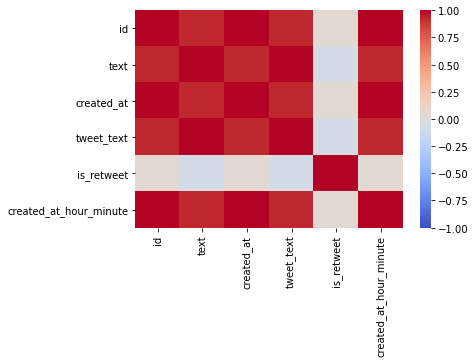

In [23]:
sns.heatmap(en_tweets_df_numeric.corr(),
            vmin=-1,
            vmax=1,
            center=0,
            cmap="coolwarm");

## Timeseries <a class="anchor" id="timeseries"></a>

In [24]:
# Group the count of tweets by their minute
timeseries = en_tweets_df[en_tweets_df['created_at_hour_minute']>='2018-05-26 18:46:00+00:00'].groupby([en_tweets_df['created_at_hour_minute']]).id.count()

(array([736840.78125   , 736840.79166667, 736840.80208333, 736840.8125    ,
        736840.82291667, 736840.83333333, 736840.84375   , 736840.85416667,
        736840.86458333]),
 <a list of 9 Text major ticklabel objects>)

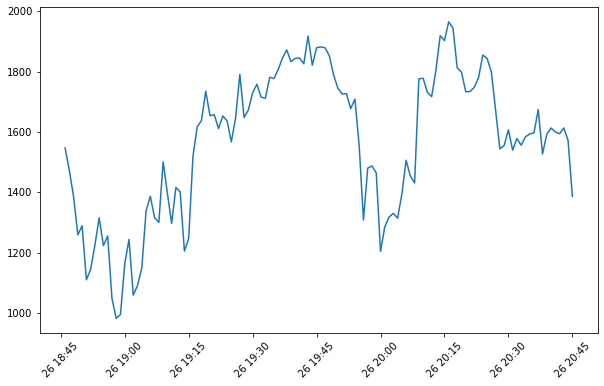

In [25]:
# Plot the timeseries
fig, ax = plt.subplots()
fig.set_size_inches(10,6)
ax.plot(timeseries.index, timeseries.values)
plt.xticks(rotation=45)

## Wordcloud <a class="anchor" id="wordcloud"></a>

In [26]:
# Based on the tutorial provided here https://towardsdatascience.com/create-your-own-word-cloud-705798556574
words = ""

# Loop through the text tweet identifying words in lower case
for i in en_tweets_df.tweet_text: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
      
    words += " ".join(separate)+" "

In [29]:
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
stop_words += ['ucl', 'uclfinal', 'http', 'https', 'co', 'rt'] # additions after running the wordcloud

final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(words)

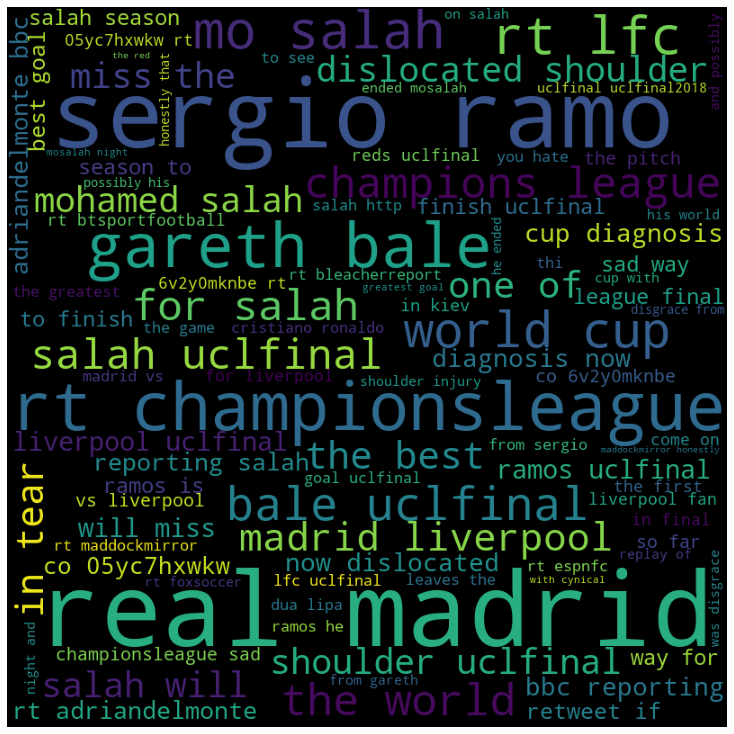

In [35]:
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()